# Analysing the arXiv

*This notebook first appeared as a [blog post](//betatim.github.io/posts/analysing-the-arxiv) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2014, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

This post is about what you can learn about scientific articles posted on the [arXiv](http://arxiv.org) by using Natural Language Processing (NLP). Said differently: I had some questions about papers posted on the arXiv and used it as an excuse to teach myself the basics of NLP. We also look at citation counts and reveal the top cited paper of 2014!

The arXiv makes its data available via a simple API which allows you to download almost everything about an article short of its full text. For each article we can look up information about who has been citing it on [inspire](http://inspirehep.net/). Combined this is a powerful dataset that can answer some interesting questions like: what are the most used words, can we auto generate abstracts, what about summarising abstracts or finding the most cited article of 2014.

Let's get going!

First some standard imports that we will need later. Some of them you might need to install but nothing too obscure:

In [2]:
import time
import urllib2# python2
import urllib
import datetime
from itertools import ifilter
from collections import Counter, defaultdict
import xml.etree.ElementTree as ET
import h5py
from bs4 import BeautifulSoup
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import bibtexparser

pd.set_option('mode.chained_assignment','warn')

In [3]:
%matplotlib inline

The `harvest` function will query the arXiv API for all articles modified between January, 1st 2010 and the end of the year 2014. This is a subtlety worth noting: with this query you will also get articles _created_ before 2010 if their entry was modified after 2010.

The arXiv itself covers so many topics that it is organised into seperate arxivs (I know unfortunate doulbe use of the name arxiv), one for each topic. By default `harvest` will collect articles from the `physics:hep-ex` arxiv. This is because I am a experimental particle physicist. If you are into theory try `physics:hep-th` or `stats` if you are a stats guru. The API gives you a [full list of all sets of topics](http://export.arxiv.org/oai2?verb=ListSets) to explore.

If you do not care for the technicalities of how to scrape the data skip right ahead to the first [factoid](#factoid).


## Harvesting articles

Most of `harvest` is pretty straight forward. The API returns a big XML document containing information about at most 1000 articles which we can parse with `ElementTree` and store. If there are more than 1000 articles for a particular query we can get those using the `resumptionToken` in the XML. API access can be throttled so on occasion the arXiv will reply with a 503 error asking us to retry later. The information we harvest is stored in a `pandas` dataframe.

<set>
<setSpec>physics:astro-ph</setSpec>
<setName>Astrophysics</setName>
</set>

In [5]:
OAI = "{http://www.openarchives.org/OAI/2.0/}"
ARXIV = "{http://arxiv.org/OAI/arXiv/}"

def harvest(arxiv="physics:astro-ph",yearstart=2017):
    df = pd.DataFrame(columns=("title", "abstract", "categories", "created", "id", "doi"))
    base_url = "http://export.arxiv.org/oai2?verb=ListRecords&"
    url = (base_url +
           "from=%i-01-01&until=%i-12-31&"%(yearstart,yearstart) +
           "metadataPrefix=arXiv&set=%s"%arxiv)
    
    while True:
        print "fetching", url
        try:
            response = urllib2.urlopen(url)
            
        except urllib2.HTTPError, e:
            if e.code == 503:
                to = int(e.hdrs.get("retry-after", 30))
                print "Got 503. Retrying after {0:d} seconds.".format(to)

                time.sleep(to)
                continue
                
            else:
                raise
            
        xml = response.read()

        root = ET.fromstring(xml)

        for record in root.find(OAI+'ListRecords').findall(OAI+"record"):
            arxiv_id = record.find(OAI+'header').find(OAI+'identifier')
            meta = record.find(OAI+'metadata')
            info = meta.find(ARXIV+"arXiv")
            created = info.find(ARXIV+"created").text
            created = datetime.datetime.strptime(created, "%Y-%m-%d")
            categories = info.find(ARXIV+"categories").text

            # if there is more than one DOI use the first one
            # often the second one (if it exists at all) refers
            # to an eratum or similar
            doi = info.find(ARXIV+"doi")
            if doi is not None:
                doi = doi.text.split()[0]
                
            contents = {'title': info.find(ARXIV+"title").text,
                        'id': info.find(ARXIV+"id").text,#arxiv_id.text[4:],
                        'abstract': info.find(ARXIV+"abstract").text.strip(),
                        'created': created,
                        'categories': categories.split(),
                        'doi': doi,
                        }

            df = df.append(contents, ignore_index=True)

        # The list of articles returned by the API comes in chunks of
        # 1000 articles. The presence of a resumptionToken tells us that
        # there is more to be fetched.
        token = root.find(OAI+'ListRecords').find(OAI+"resumptionToken")
        if token is None or token.text is None:
            break

        else:
            url = base_url + "resumptionToken=%s"%(token.text)
            
    return df
    

Set `harvest` running and go chat with someone for a few minutes while it gathers the information about your articles.

In [8]:
df = harvest(arxiv="physics:astro-ph",yearstart=2017)

fetching http://export.arxiv.org/oai2?verb=ListRecords&from=2017-01-01&until=2017-12-31&metadataPrefix=arXiv&set=physics:astro-ph
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3124377|1001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3124377|2001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3124377|3001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3124377|4001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3124377|5001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3124377|6001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3124377|7001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3124377|8001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3124377|9001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3124377|10001
fetching http://export.arxiv.

What does all that stuff we just downloaded look like? Here are the first five entries in the dataframe:

(100710, 117495, 100710, 100710)

In [3]:
df.head()

NameError: name 'df' is not defined

## First factoid
<a id="factoid"></a>

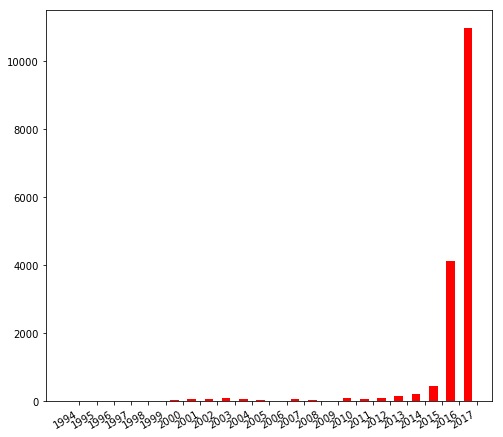

Unique arXiv IDs edited between 2015 and 2017: 16785
of which 15561 entries were created in that time period.


In [31]:
def bar_chart(items):
    """Make a bar chart showing the count associated with each key
    
    `items` is a list of (key, count) pairs.
    """
    width = 0.5
    ind = np.arange(len(items))
    fig, ax = plt.subplots(figsize=(8,8))
    rects1 = ax.bar(ind, zip(*items)[1], width, color='r')
    ax.set_xticks(ind+width)
    ax.set_xticklabels(zip(*items)[0])
    fig.autofmt_xdate()
    plt.show()

edits_per_year = Counter(df.created.map(lambda x: x.year))
bar_chart(edits_per_year.items())
new_articles = sum(edits_per_year[year] for year in (2017))
print "Unique arXiv IDs edited between 2017-01-01 and 2017-12-31:", len(df.id.unique())
print "of which %i entries were created in 2017."%(new_articles)

In [ ]:
edits_per_year

Here is our first factoid about the arXiv: There are about 16000 articles in `hep-ex` which were edited between the beginning of 2010 and the end of 2014. Including about 12000 newly created articles. The other 4000 papers were created before 2010 and were updated after creation. Amazing to see that papers created in 1994 were still being edited almost ten years later!

Let's take a look at those, maybe there is something interesting:

In [37]:
df[df.created<datetime.date(2017,1,1)].size,df[df.created>datetime.date(2017,1,1)].size

(34866, 65766)

In [38]:
df[df.created<datetime.date(2005,1,1)]

,title,abstract,categories,created,id,doi
16303,Probing the Cosmic Dark Age in X-rays,Empirical studies of the first generation of s...,[astro-ph],2000-01-14,astro-ph/0001271,10.1063/1.1434627
16304,Formation of Molecular Gas in the debris of vi...,In many gravitational interactions between gal...,[astro-ph],2000-02-08,astro-ph/0002177,10.1038/35009156
16305,Resolving the extragalactic hard X-ray background,The origin of the hard (2-10 keV) X-ray backgr...,[astro-ph],2000-02-16,astro-ph/0002313,10.1038/35006564
16306,The Mystery of Ultra-High Energy Cosmic Rays,The origin of cosmic rays with energies higher...,[astro-ph],2000-03-01,astro-ph/0003013,10.1142/9789812792846_0005
16307,Detection of weak gravitational lensing distor...,Most of the matter in the universe is not lumi...,[astro-ph],2000-03-01,astro-ph/0003014,10.1038/35012001
16308,Galactic Worm 123.4-1.5: A Mushroom-shaped HI ...,The Dominion Radio Astrophysical Observatory's...,[astro-ph],2000-03-06,astro-ph/0003081,10.1086/312592
16309,Supernovae,The properties of supernovae (SNe) are reviewe...,[astro-ph],2000-03-06,astro-ph/0003083,10.1142/9789812792846_0003
16310,The Quest for Quantum Gravity: Testing Times f...,I discuss some theoretical ideas concerning th...,"[astro-ph, gr-qc, hep-ph]",2000-04-17,astro-ph/0004225,10.1142/9789812811752_0033
16311,Cosmic Phase Transitions,The sequence of phase transitions during the h...,"[astro-ph, nucl-th]",2000-04-28,astro-ph/0004403,10.1002/1521-3889(200009)9:8<605::AID-ANDP605>...
16312,The exact solution of the Riemann problem with...,We have generalised the exact solution of the ...,"[astro-ph, physics.flu-dyn]",2000-05-02,astro-ph/0005038,10.1017/S0022112000001439


After scrolling through the list I can not spot a particular pattern to the edits. Though it does seem like the list contains articles on interesting topics like evidence for the top quark (index 15148), PeV $\tau$ neutrinos (index 16113) and an article about determining the weak mixing angle at SLD (index 15149).

## Collecting citations

Unfortunately Inspire does not provide a real API, so we have to scrape their webpages to get what we want. The `get_cites` function will look up the citations of an article by its `arxiv_id`. Having to make one HTTP request per article means this takes quite a while. So set it going and come back after a few hours. We process articles in chunks of 1000 to get some feedback as well as being able to resume if something goes wrong:

In [52]:
len(df)

16785

In [54]:
def get_cites(arxiv_id):
    cites = []
    base_url = "http://inspirehep.net/search?p=refersto:%s&of=hx&rg=250&jrec=%i"
    offset = 1
    
    while True:
        print base_url%(arxiv_id, offset)
        response = urllib2.urlopen(base_url%(arxiv_id, offset))
        xml = response.read()
        soup = BeautifulSoup(xml)

        refs = "\n".join(cite.get_text() for cite in soup.findAll("pre"))

        bib_database = bibtexparser.loads(refs)
        if bib_database.entries:
            cites += bib_database.entries
            offset += 250
            
        else:
            break

    return cites


http://inspirehep.net/search?p=refersto:0704.0603&of=hx&rg=250&jrec=1
http://inspirehep.net/search?p=refersto:0704.2108&of=hx&rg=250&jrec=1
http://inspirehep.net/search?p=refersto:0704.2108&of=hx&rg=250&jrec=251
http://inspirehep.net/search?p=refersto:0705.1208&of=hx&rg=250&jrec=1
http://inspirehep.net/search?p=refersto:0705.1208&of=hx&rg=250&jrec=251
http://inspirehep.net/search?p=refersto:0705.1240&of=hx&rg=250&jrec=1
http://inspirehep.net/search?p=refersto:0705.1240&of=hx&rg=250&jrec=251
http://inspirehep.net/search?p=refersto:0705.1771&of=hx&rg=250&jrec=1
http://inspirehep.net/search?p=refersto:0705.1771&of=hx&rg=250&jrec=251
http://inspirehep.net/search?p=refersto:0705.2017&of=hx&rg=250&jrec=1
http://inspirehep.net/search?p=refersto:0705.2017&of=hx&rg=250&jrec=251
http://inspirehep.net/search?p=refersto:0706.0278&of=hx&rg=250&jrec=1
http://inspirehep.net/search?p=refersto:0706.0278&of=hx&rg=250&jrec=251
http://inspirehep.net/search?p=refersto:0706.1279&of=hx&rg=250&jrec=1
http://i

ParseException: Expected end of text (at char 1207), (line:39, col:1)

In [ ]:
step = 1000
for N in range(0,1):
    cites = df['id'][N*step:(N+1)*step].map(get_cites)
    df.ix[N*step:(N+1)*step -1,'cited_by'] = cites
    print N

In [ ]:
for N in range(5,8):
    cites = df['id'][N*step:(N+1)*step].map(get_cites)
    df.ix[N*step:(N+1)*step -1,'cited_by'] = cites
    print N    

In [ ]:
for N in range(9,12):
    cites = df['id'][N*step:(N+1)*step].map(get_cites)
    df.ix[N*step:(N+1)*step -1,'cited_by'] = cites
    print N

In [ ]:
for N in range(13,17):
    cites = df['id'][N*step:(N+1)*step].map(get_cites)
    df.ix[N*step:(N+1)*step -1,'cited_by'] = cites
    print N

In [55]:
df['cited_by']

KeyError: 'cited_by'

In [56]:
ls ./arxiv-experiments/*

./arxiv-experiments/astro-ph2017.csv  ./arxiv-experiments/astro-ph2017.pkl
./arxiv-experiments/astro-ph2017.h5


## Data preservation

After investing so much time to gather the raw data it is a good idea to store it locally so we do not have to scrape it all again later:

In [ ]:
#mkdir arxiv-experiments
df.to_csv("./arxiv-experiments/astro-ph2017.csv",encoding='utf-8')
df2017csv=pd.read_csv("./arxiv-experiments/astro-ph2017.csv")

df.to_pickle("./arxiv-experiments/astro-ph2017.pkl")  # where to save it, usually as a .pkl
df2017pkl = pd.read_pickle("./arxiv-experiments/astro-ph2017.pkl") # load it back using

store = pd.HDFStore('./arxiv-experiments/astro-ph2017.h5')
store['df'] = df  # save it
df2017h5=store['df']  # load it
store.close()
df.size,df2017csv.size,df2017pkl.size,df2017h5.size

In [58]:
df.head()

,title,abstract,categories,created,id,doi
0,The height dependence of temperature - velocit...,We derive correlation coefficients between tem...,[astro-ph],2007-04-04,0704.0603,None
1,A Near-Infrared Study of the Highly-Obscured A...,We present wide-field JHKs-band photometric ob...,[astro-ph],2007-04-17,0704.2108,10.5303/JKAS.2007.40.1.017
2,Utilization of photon orbital angular momentum...,We show numerically that vector antenna arrays...,"[astro-ph, physics.class-ph]",2007-05-09,0705.1208,10.1103/PhysRevLett.99.087701
3,Quark-nova explosion inside a collapsar: appli...,"If a quark-nova occurs inside a collapsar, the...",[astro-ph],2007-05-09,0705.1240,10.1155/2009/463521
4,Performance of the Charge Injection Capability...,A charge injection technique is applied to the...,[astro-ph],2007-05-12,0705.1771,10.1093/pasj/60.sp1.S1


In [ ]:
pwd

## Word counts

Let's get to answering some questions. What are the ten most used words in `hep-ex` abstracts?

In [ ]:
word_bag = " ".join(df.abstract.apply(lambda t: t.lower()))

Counter(word_bag.split()).most_common(n=100)[20:]

Not too enlightening, boring little words close out the top ten. These words are known as stopwords and the `NLTK` library provides a list of all of them. So let's remove them as well as basic mathematical symbols:

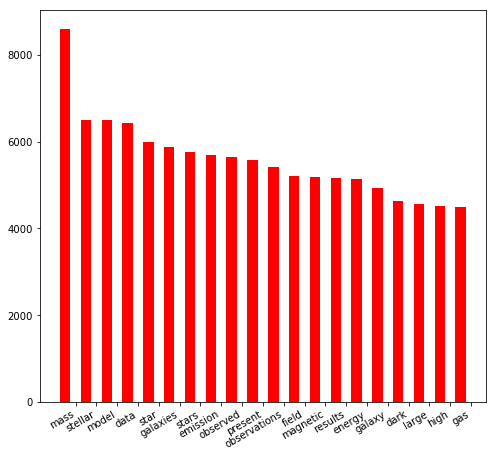

In [46]:
from nltk.corpus import stopwords

stops = [word for word in stopwords.words('english')]
stops += ["=", "->","find",'two','one','using','also','show','use']
words = filter(lambda w: w not in stops,
               word_bag.split())
top_twenty = Counter(words).most_common(n=20)

bar_chart(top_twenty)

Experimental physics is all about data afterall! A shame that `model` beats `detector` but probably that is inevitable as there are many more theoretical models than experimental detectors. The `higgs` boson beats the `neutrino` but they reign supreme over all the other particles.

Towards the bottom we have `measurements` and `measured`. These should probably be counted as one entry, together with `measurement`, `measuring`, etc. The easiest way to achieve this is to stem the words before counting. [Stemming](http://en.wikipedia.org/wiki/Stemming) is the process of reducing derived words to their stem, for example:

In [41]:
import nltk.stem as stem

porter = stem.PorterStemmer()
for w in ("measurement", "measurements", "measured", "measure"):
    print w, "->", porter.stem(w)

measurement -> measur
measurements -> measur
measured -> measur
measure -> measur


Like in this case the stem does not have to be a real word itself. By stemming words before counting how often they occur the entries for `measurements` and `measured` get added together. Using the stem of every word we get the following ranking:

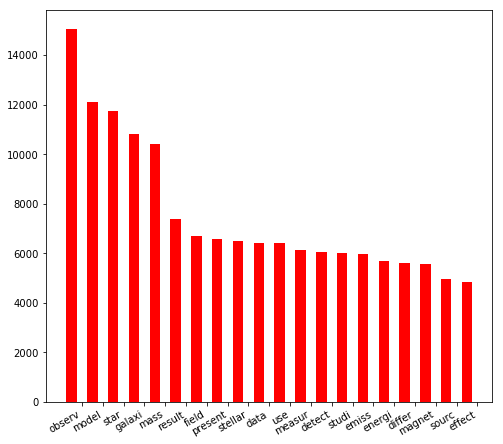

observ <- observational, observable, observation, observer, observes, observing, observed, observe, observations, observationally, observables, observability, observers, observably
model <- models, modelings, modellers, modeled, modelization, modelling, modelized, modelled, modeling, model, modelers
star <- star, stars
galaxi <- galaxies, galaxy
mass <- masse, masses, mass
result <- resulted, resultant, resulting, results, result
field <- field, fielding, fields
present <- presently, presented, presentations, presents, presenting, presentation, present
stellar <- stellar, stellare
data <- data
use <- use, used, useful, usefully, uses, usefulness
measur <- measuring, measures, measureables, measurements, measure, measurable, measurably, measurability, measurement, measured
detect <- detect, detectability, detections, detectably, detection, detected, detectable, detecting, detects, detectabilities
studi <- studying, study, studied, studies
emiss <- emissive, emissivities, emission, emiss

In [47]:
word_stems = map(lambda w: (porter.stem(w),w), words)
stem2words = defaultdict(set)
for stem, word in word_stems:
    stem2words[stem].add(word)

top_twenty = Counter(w[0] for w in word_stems).most_common(n=20)

bar_chart(top_twenty)

# list all words which correspond to each top twenty stem
for stem,count in top_twenty:
    print stem, "<-", ", ".join(stem2words[stem])

Turns out experimental phsics is all about measuring things. The stemming is not perfect, but good enough for now.


## Cite me, cite me, no cite me!

In science citations is the currency used to measure the success of a paper. What does the distribution of citations look like then?

A simple question to ask is: how often are articles cited? As articles have to be read and understood before they can be cited we only look at articles created before the beginning of 2014.

In [48]:
before_2017 = datetime.datetime(2017,1,1)
plt.hist(df[df.created<before_2017].cited_by.map(len),
         bins=200, normed=True, range=(0,200))
plt.xlabel("Number of citations")
plt.ylabel("Fraction")

AttributeError: 'DataFrame' object has no attribute 'cited_by'

This plot shows the fraction of articles cited zero, one, two, three, ... times. The single most likely number of citations for an article on `hep-ex` is zero! A whopping 13% of articles never get cited and nearly a third of articles are cited less than four times.

In [233]:
df['citation_count'] = df.cited_by.map(len)
df[df.created<before_2014]['citation_count'].describe()

count    14059.000000
mean        32.630486
std        100.773436
min          0.000000
25%          2.000000
50%         10.000000
75%         31.000000
max       4138.000000
Name: citation_count, dtype: float64

The average number of citations is about 33. The average is misleading for a steeply falling distribution like this, afterall we reach the 50% percentile at only 10 citations!

## Citations top ten
<a id="topten"></a>

The prize for most cited paper with a whopping 4138 citations goes to:

In [234]:
df.iloc[df.citation_count.idxmax()]

title             New Generation of Parton Distributions with Un...
abstract          A new generation of parton distribution functi...
categories                                         [hep-ph, hep-ex]
created                                         2002-01-21 00:00:00
id                                                   hep-ph/0201195
doi                                   10.1088/1126-6708/2002/07/012
cited_by          [{u'slaccitation': u'%%CITATION = ARXIV:1412.4...
citation_count                                                 4138
Name: 15779, dtype: object

Read the paper yourself: [New Generation of Parton Distributions with Uncertainties from Global QCD Analysis](http://arxiv.org/abs/hep-ph/0201195) and see if you agree.

We can also easily compute the top ten papers. This is an interesting mix of articles. Number two and three are the papers by the [ATLAS](http://atlas.ch) and [CMS](http://cms.web.cern.ch/) experiments reporting on the discovery of the [Higgs boson](http://en.wikipedia.org/wiki/Higgs_boson). While most of the papers in the top ten are older these two were only published in 2012 and have already overtaken the top quark discovery which was published in 1995! Curious fact, the ATLAS paper has ever so few more citations than the CMS one.

In [241]:
df.sort('citation_count', ascending=False).head(10)

,title,abstract,categories,created,id,doi,cited_by,citation_count
15779,New Generation of Parton Distributions with Un...,A new generation of parton distribution functi...,"[hep-ph, hep-ex]",2002-01-21,hep-ph/0201195,10.1088/1126-6708/2002/07/012,[{u'slaccitation': u'%%CITATION = ARXIV:1412.4...,4138
7371,Observation of a new particle in the search fo...,A search for the Standard Model Higgs boson in...,[hep-ex],2012-07-31,1207.7214,10.1016/j.physletb.2012.08.020,[{u'slaccitation': u'%%CITATION = ARXIV:1412.4...,3653
7372,Observation of a new boson at a mass of 125 Ge...,Results are presented from searches for the st...,[hep-ex],2012-07-31,1207.7235,10.1016/j.physletb.2012.08.021,[{u'slaccitation': u'%%CITATION = ARXIV:1412.4...,3592
15181,Observation of Top Quark Production in Pbar-P ...,We establish the existence of the top quark us...,"[hep-ex, hep-ph]",1995-03-02,hep-ex/9503002,10.1103/PhysRevLett.74.2626,[{u'slaccitation': u'%%CITATION = ARXIV:1412.4...,2519
16241,Direct Evidence for Neutrino Flavor Transforma...,Observations of neutral current neutrino inter...,"[nucl-ex, hep-ex]",2002-04-21,nucl-ex/0204008,10.1103/PhysRevLett.89.011301,[{u'slaccitation': u'%%CITATION = ARXIV:1412.4...,2425
15690,HERWIG 6.5: an event generator for Hadron Emis...,HERWIG is a general-purpose Monte Carlo event ...,"[hep-ph, hep-ex]",2000-11-29,hep-ph/0011363,10.1088/1126-6708/2001/01/010,[{u'slaccitation': u'%%CITATION = ARXIV:1412.4...,2324
14026,First Results from KamLAND: Evidence for React...,KamLAND has been used to measure the flux of $...,"[hep-ex, nucl-ex]",2002-12-09,hep-ex/0212021,10.1103/PhysRevLett.90.021802,[{u'slaccitation': u'%%CITATION = ARXIV:1412.4...,2235
16152,A Supersymmetry Primer,I provide a pedagogical introduction to supers...,"[hep-ph, hep-ex, hep-th]",1997-09-15,hep-ph/9709356,None,[{u'slaccitation': u'%%CITATION = ARXIV:1412.4...,2160
16235,Measurement of the rate of nu_e + d --> p + p ...,Solar neutrinos from the decay of $^8$B have b...,"[nucl-ex, hep-ex]",2001-06-18,nucl-ex/0106015,10.1103/PhysRevLett.87.071301,[{u'slaccitation': u'%%CITATION = ARXIV:1412.4...,2030
13678,The BABAR Detector,"BABAR, the detector for the SLAC PEP-II asymme...",[hep-ex],2001-05-16,hep-ex/0105044,10.1016/S0168-9002(01)02012-5,[{u'title': u'Measurement of the Partial Branc...,1828


There are many more interesting things to be done with analysing the words used in abstracts as well as anlysing who cites who. This will be covered in the second part of this post as this one is already fairly lengthy.

Just one more thing, the top cited paper of 2014: [First combination of Tevatron and LHC measurements of the top-quark mass](http://arxiv.org/abs/1403.4427) celebrating collaboration across the globe:

In [242]:
df.iloc[df[df.created>before_2014].citation_count.idxmax()]

title             First combination of Tevatron and LHC measurem...
abstract          We present a combination of measurements of th...
categories                                                 [hep-ex]
created                                         2014-03-18 00:00:00
id                                                        1403.4427
doi                                                            None
cited_by          [{u'slaccitation': u'%%CITATION = ARXIV:1412.1...
citation_count                                                  118
Name: 11494, dtype: object